In [9]:
import mesa
import random
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

In [10]:
class CelulaTerreno(mesa.Agent):
    def __init__(self, model, elevacao, infiltracao):
        super().__init__(model)
        self.elevacao = elevacao # altura do terreno
        self.infiltracao = infiltracao  # taxa de infiltração (entre 0 e 1)
        self.agua_acumulada = 0
        self.estado = "seco"

    def step(self):
        self.agua_acumulada += self.model.precipitacao

        self.agua_acumulada -= self.infiltracao * self.agua_acumulada

        vizinhos = self.model.grid.get_neighbors(
            self.pos,
            moore=True,
            include_center=False,
        )

        for vizinho in vizinhos:
            altura_self = self.elevacao + self.agua_acumulada
            altura_vizinho = vizinho.elevacao + vizinho.agua_acumulada
            if altura_self > altura_vizinho:
                diferenca = altura_self - altura_vizinho
                fluxo = 0.2 * diferenca
                fluxo = min(fluxo, self.agua_acumulada)

                self.agua_acumulada -= fluxo
                vizinho.agua_acumulada += fluxo

        if self.agua_acumulada > 5:
            self.estado = "alagado"
        elif self.agua_acumulada > 1:
            self.estado = "molhado"
        else:
            self.estado = "seco"

In [11]:
class Inundacao(mesa.Model):
    def __init__(self, largura, altura, precipitacao):
        super().__init__()
        self.grid = mesa.space.MultiGrid(largura, altura, torus=False)
        self.precipitacao = precipitacao

        for x in range(largura):
            for y in range(altura):
                elevacao = random.uniform(0, 10)  # altura entre 0 e 10 metros
                infiltracao = random.uniform(0, 1)  # taxa de infiltração entre 0 e 1

                agente = CelulaTerreno(self, elevacao, infiltracao)
                self.grid.place_agent(agente, (x, y))

    def step(self):
        self.agents.shuffle_do("step")

In [18]:
def grid_para_matriz(model):
    largura = model.grid.width
    altura = model.grid.height

    matriz = np.zeros((altura, largura))

    for agents, (x, y) in model.grid.coord_iter():
        if agents:
            agente = agents[0]
            matriz[y, x] = agente.agua_acumulada

    return matriz

def plotar_grid(model):
    matriz = grid_para_matriz(model)

    plt.figure(figsize=(6, 6))
    plt.imshow(matriz, cmap="Blues", origin="lower")
    plt.colorbar(label="Água acumulada")
    plt.title("Simulação de Inundação")
    plt.show()


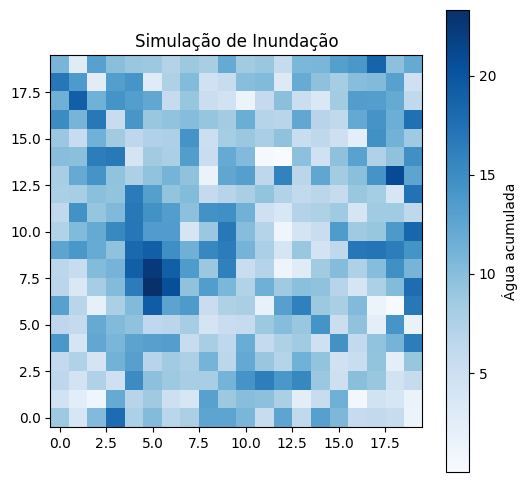

In [20]:

model = Inundacao(largura=20, altura=20, precipitacao=10)

for step in range(30):
    clear_output(wait=True)
    model.step()
    plotar_grid(model)